# Binary stars evolutions and binary black holes

Giacomo Menegatti, Dario Puggioni, Laura Schulze, Savina Tsichli

Next steps: 
- maybe perform GridSearch to optimize parameters?
- figure out how to assess feature importance
- compare results for most important features with the visualisation group
- compare with theory?

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("darkgrid")
import time
import sklearn.utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance


## Loading the dataset
The dataset is divided in files depending on the CE efficiency $ \alpha $ and the metallicity $ Z $ of the two stars. All the data are loaded into a pandas dataframe containing also the two parameters.


In [2]:

alpha = [0.5, 1, 3, 5] # CE efficiency
Z = [2e-4, 4e-4, 8e-4, 1.2e-3, 1.6e-3, 2e-3, 4e-3, 6e-3, 8e-3, 1.2e-2, 1.6e-2, 2e-2]  #Metallicity value

data = [] #Data list 

sim_data = pd.DataFrame({'alpha':[], 'Z':[], 'MtotZAMS':[], 'num_mergers':[]})
#Appending all the values in a single big dataframe

index = 0
for a in alpha:
  for m in Z:
    # The simulation data first row contains the MtotZAMS and the number of merger for each alpha and metallicity 
    df = pd.read_csv(f'stable_MT_vs_CE/A{a}/MTCE_BBHs_{m}.txt', sep=' ', nrows = 1, header=0) 
    sim_data.loc[index] = [a, m, df.iloc[0,0], df.iloc[0,1]]  #Adding the row to the sim_data df
    index = index + 1 

    df = pd.read_csv(f'stable_MT_vs_CE/A{a}/MTCE_BBHs_{m}.txt', header=2, sep= ' ')     # Simulation data
    df['alpha'],df['Z'] = a, m                                 #Adding the alpha and Z paramtere in the table
    
    data.append(df)

data = pd.concat(data)
data.columns = [name[name.find(':')+1:] for name in data.columns] #The data header are col.i: this deletes the first part
print('Data columns: \n ', data.columns.values)

data.reset_index(drop=True, inplace=True)


Data columns: 
  ['ID' 'm1ZAMS/Msun' 'm2ZAMS/Msun' 'm1rem/Msun' 'm2rem/Msun'
 'm1rem+m2rem/Msun' 'delay_time/Myr' 'sma/Rsun' 'ecc' 'kick/kms'
 'kick/kms' 'cmu1' 'cmu2' 'v1x/kms' 'v1y/kms' 'v1z/kms' 'v2x/kms'
 'v2y/kms' 'v2z/kms' 'time_SN1/Myr' 'time_SN2/Myr' 'CE' 'alpha' 'Z']


In [3]:
CE_data = data[data['CE']==True]
MT_data = data[data['CE']==False]
print(f'There are {CE_data.shape[0]} samples')


There are 2551001 samples


 ## RF playground
 
 TODO: Run some simple machine learning algorithm (e.g., a random forest) to figure out what features 
have the highest impact on the fate of a binary black hole, that is to decide if the binary system 
evolves via mass transfer or common envelope.

In [4]:
# prepare data X and labels y
# drop ID column
X = data.drop(columns=['ID', 'CE'])
y = data['CE']

# split data into training and test set
# for now: 10% of data as training set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.9, random_state=100)


In [5]:
# initialise random forest classifier
# using n_jobs=-1 saves quite a bit of time (~80s with vs ~430s without)
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# train random forest
# let's time this for fun
ts = time.time()
clf.fit(X_train, y_train)
print("Training time: %.2f s"%(time.time()-ts))

# evaluate training & test accuracy
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)


Training time: 48.20 s
Training accuracy:  1.0
Test accuracy:  0.9984114570054858


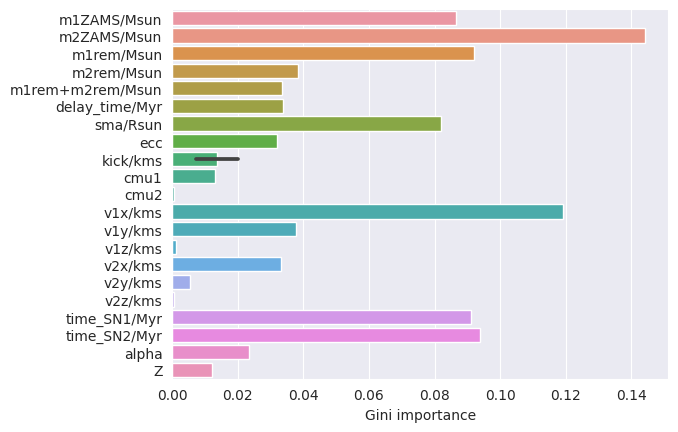

In [6]:
# save params + importances to dataframe
importances = pd.DataFrame(zip(clf.feature_names_in_, clf.feature_importances_),
                           columns=["param", "gini"])

# sort importances
#importances = importances.sort_values(by="gini", ascending= False)

# plot importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='gini', data=importances, ax=ax)
#ax.tick_params(axis='x', rotation=90) #for params on x and gini on y
ax.set_ylabel('')
ax.set_xlabel('Gini importance')
plt.show()


"**Warning**: Impurity-based feature importances can be misleading for **high cardinality** features (many unique values)." - according to [scikit-learn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html). So let's try out **Permutation feature importance** as well!

In [7]:
# compute permutation feature importances
# using sklearn.inspection.permutation_importance
# warning: takes a lot of time to compute! (~64min)
ts = time.time()
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
print("importance calculation time: {:.2f} s".format(time.time() - ts))


: 

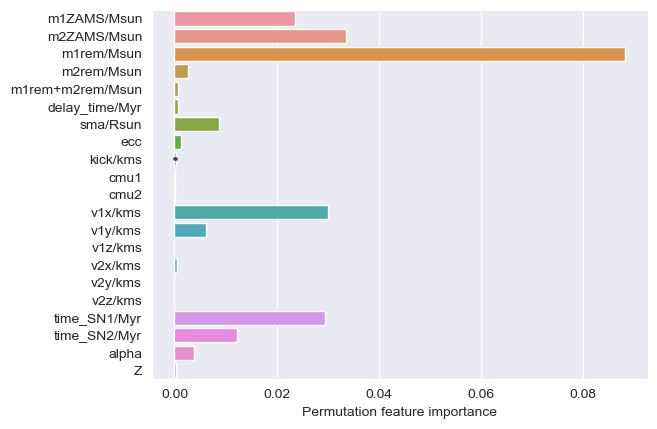

In [ ]:
importances['permutation'] = result.importances_mean

# plot importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='permutation', data=importances, ax=ax)
#ax.tick_params(axis='x', rotation=90) #for params on x and importance on y
ax.set_ylabel('')
ax.set_xlabel('Permutation feature importance')
plt.show()


In [ ]:
importances


,param,gini,permutation
0,m1ZAMS/Msun,0.086421,0.023518
1,m2ZAMS/Msun,0.144062,0.033555
2,m1rem/Msun,0.091984,0.088200
3,m2rem/Msun,0.038429,0.002718
4,m1rem+m2rem/Msun,0.033413,0.000641
5,delay_time/Myr,0.033703,0.000710
6,sma/Rsun,0.081828,0.008716
7,ecc,0.032007,0.001333
8,kick/kms,0.019944,0.000232
9,kick/kms,0.007136,0.000187


I don't think it will be necessary, but we can visualise trees using [sklearn.tree.plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html):

In [ ]:
# plot a decision tree
# just for fun :D
fig = plt.figure(figsize=(15, 10))
plot_tree(clf.estimators_[0], 
          feature_names=list(X.columns),
          class_names=['MT', 'CE'],
          max_depth=2,
          fontsize=10,
          filled=True, rounded=True)
plt.show()


The `RandomForestClassifier` in sklearn has a variety of parameters we could potentially adjust & optimize. What might be useful? (from the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)):

- `n_estimators` int, default=100: 

    number of trees in the forest

- `criterion`{“gini”, “entropy”, “log_loss”}, default=”gini”:

    The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain, see Mathematical formulation. Note: This parameter is tree-specific.

- `max_depth` int, default=None:

    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    
- `min_samples_split` int or float, default=2:

    The minimum number of samples required to split an internal node:
    If int, then consider min_samples_split as the minimum number. 
    If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
    
- `min_samples_leaf` int or float, default=1:

    The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
    If int, then consider min_samples_leaf as the minimum number.
    If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.
 
- `min_weight_fraction_leaf` float, default=0.0:

    The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.

- `max_features`{“sqrt”, “log2”, None}, int or float, default=”sqrt”:

    The number of features to consider when looking for the best split:

    * If int, then consider max_features features at each split.

    * If float, then max_features is a fraction and max(1, int(max_features * n_features_in_)) features are considered at each split.

    * If “sqrt”, then max_features=sqrt(n_features).

    * If “log2”, then max_features=log2(n_features).

    * If None, then max_features=n_features.
    
    
- `bootstrap`bool, default=True:
    Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.


- `max_samples` int or float, default=None

    If bootstrap is True, the number of samples to draw from X to train each base estimator.
    If None (default), then draw X.shape[0] samples.
    If int, then draw max_samples samples.
    If float, then draw max(round(n_samples * max_samples), 1) samples. Thus, max_samples should be in the interval (0.0, 1.0].

- `n_jobs` int, default=None:

    The number of jobs to run in parallel. fit, predict, decision_path and apply are all parallelized over the trees. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.

- `ccp_alpha` non-negative float, default=0.0

    Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed. See Minimal Cost-Complexity Pruning for details.